In [28]:
# load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')




In [3]:
# Define Spotify colors and set default style
SPOTIFY_GREEN = '#1DB954'
SPOTIFY_BLACK = '#191414'
SPOTIFY_WHITE = '#FFFFFF'

# Set default style with Spotify colors
plt.rcParams['figure.facecolor'] = SPOTIFY_BLACK
plt.rcParams['axes.facecolor'] = SPOTIFY_BLACK
plt.rcParams['text.color'] = SPOTIFY_WHITE
plt.rcParams['axes.labelcolor'] = SPOTIFY_WHITE
plt.rcParams['xtick.color'] = SPOTIFY_WHITE
plt.rcParams['ytick.color'] = SPOTIFY_WHITE

In [4]:
# here we will load the data
data = pd.read_csv('/Users/danielharrod/spotify_sentiment/data/spotify_reviews.csv')

data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


In [5]:
# see how many nan values we have
data.isna().sum()

reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64

In [6]:
def clean_text(text):
    """
    Clean text data by removing special characters and converting to lowercase
    """
    if isinstance(text, str):
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Convert to lowercase
        text = text.lower().strip()
        
        return text
    return ''

In [7]:
# Preprocess the data
try:
    # Convert date
    data['at'] = pd.to_datetime(data['at'])
    
    # Clean the content column
    data['clean_content'] = data['content'].apply(clean_text)
    
    # Display sample of cleaned text
    print("Sample of original and cleaned text:")
    sample_data = pd.DataFrame({
        'Original': data['content'].head(),
        'Cleaned': data['clean_content'].head()
    })
    print(sample_data)
    
except KeyError as e:
    print(f"Error: Column not found - {e}")
    print("Available columns:", data.columns.tolist())
except Exception as e:
    print(f"Error during preprocessing: {e}")

Sample of original and cleaned text:
                                            Original  \
0                                          It's good   
1  I love this app so much, I've been using Spoti...   
2                                            Perfect   
3  Best all around music streaming app I have use...   
4  Are y'all fr gatekeeping the play button on so...   

                                             Cleaned  
0                                           its good  
1  i love this app so much ive been using spotify...  
2                                            perfect  
3  best all around music streaming app i have use...  
4   are yall fr gatekeeping the play button on songs  


### Sentiment Analysis

In [8]:
def get_sentiment(text):
    """
    Calculate sentiment polarity score using TextBlob
    """
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    return 0

In [9]:
#Perform sentiment analysis
try:
    data['sentiment_score'] = data['clean_content'].apply(get_sentiment)
    data['sentiment_category'] = data['sentiment_score'].apply(
        lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
    )
    
    # Display sentiment distribution
    print("\nSentiment Distribution:")
    print(data['sentiment_category'].value_counts())
    print("\nSentiment Score Statistics:")
    print(data['sentiment_score'].describe())
    
except KeyError as e:
    print(f"Error: Column not found - {e}")
except Exception as e:
    print(f"Error during sentiment analysis: {e}")



Sentiment Distribution:
sentiment_category
Positive    52520
Negative    28131
Neutral      3514
Name: count, dtype: int64

Sentiment Score Statistics:
count    84165.000000
mean         0.085906
std          0.265778
min         -1.000000
25%         -0.060000
50%          0.075000
75%          0.237500
max          1.000000
Name: sentiment_score, dtype: float64


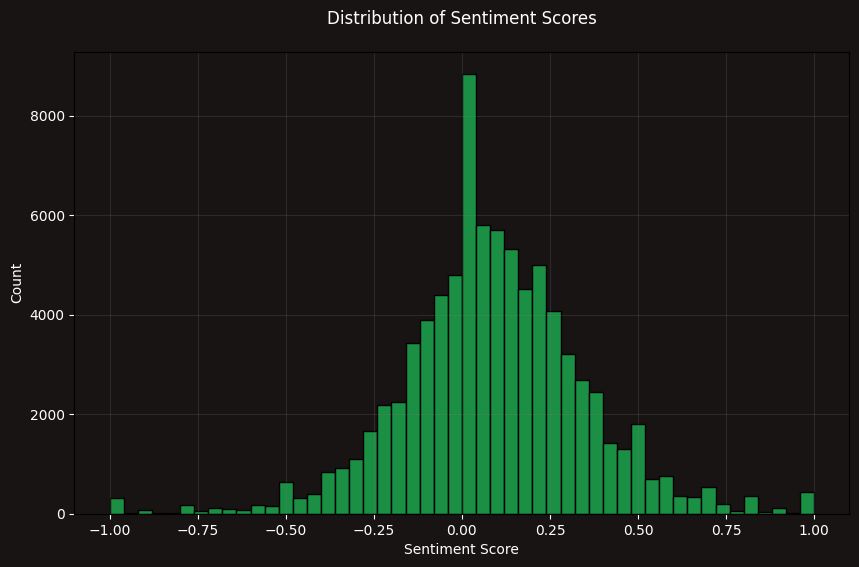

In [17]:
# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sentiment_score', bins=50, color=SPOTIFY_GREEN)
plt.title('Distribution of Sentiment Scores', color=SPOTIFY_WHITE, pad=20)
plt.xlabel('Sentiment Score', color=SPOTIFY_WHITE)
plt.ylabel('Count', color=SPOTIFY_WHITE)
plt.grid(True, color='gray', alpha=0.2)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/sentiment_distribution.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)

plt.show()



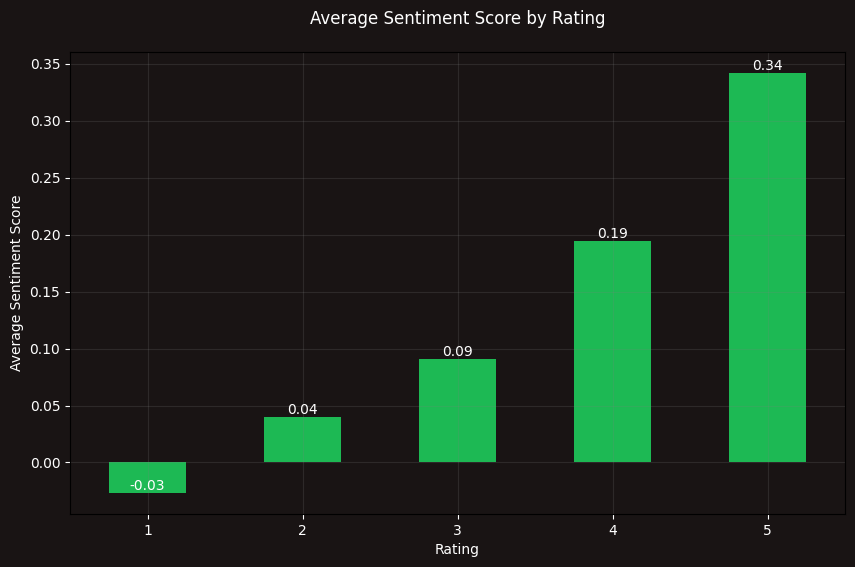

In [25]:
# 2. Average Sentiment by Rating
plt.figure(figsize=(10, 6))
ax = data.groupby('score')['sentiment_score'].mean().plot(
    kind='bar',
    color=SPOTIFY_GREEN
)
plt.title('Average Sentiment Score by Rating', color=SPOTIFY_WHITE, pad=20)
plt.xlabel('Rating', color=SPOTIFY_WHITE)
plt.ylabel('Average Sentiment Score', color=SPOTIFY_WHITE)
plt.grid(True, color='gray', alpha=0.2)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/average_sentiment_score.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)

plt.xticks(rotation=0)

# Add value labels on top of bars
for i, v in enumerate(data.groupby('score')['sentiment_score'].mean()):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', color=SPOTIFY_WHITE)
plt.show()



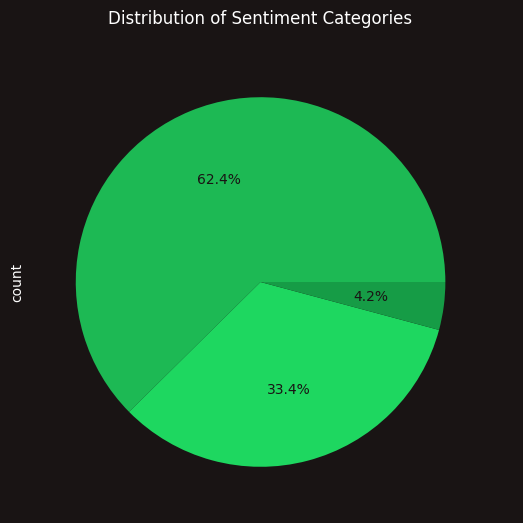

In [19]:
# 3. Sentiment Categories Distribution
plt.figure(figsize=(10, 6))
colors = [SPOTIFY_GREEN, '#1ed760', '#169c46']  # Different shades of Spotify green
data['sentiment_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=colors,
    textprops={'color': SPOTIFY_BLACK}
)
plt.title('Distribution of Sentiment Categories', color=SPOTIFY_WHITE, pad=20)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/sentiment_category_distribution.png', facecolor=SPOTIFY_BLACK, bbox_inches='tight')
plt.show()





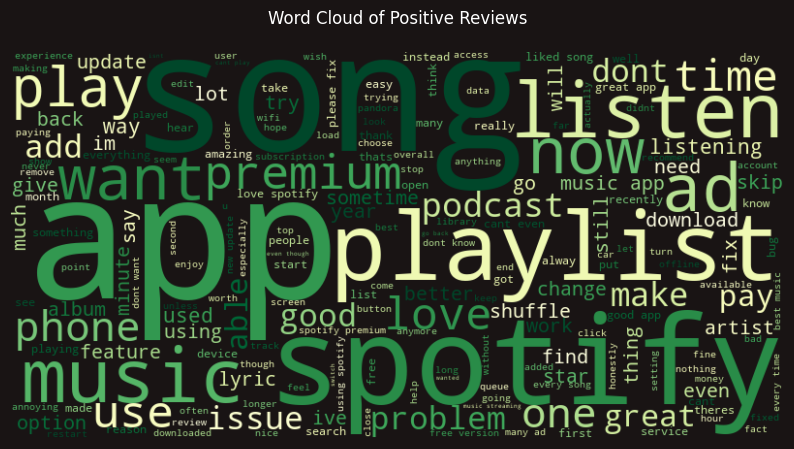

In [20]:
# Generate and display word cloud
text = ' '.join(data[data['sentiment_score'] > 0]['clean_content'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color=SPOTIFY_BLACK,
    colormap='YlGn',
    contour_color=SPOTIFY_GREEN,
    contour_width=3
).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews', color=SPOTIFY_WHITE, pad=20)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/positive_reviews_wordcloud.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)
plt.show()





In [21]:
# Analyze common words
vectorizer = CountVectorizer(max_features=10, stop_words='english')

# Positive reviews analysis
positive_text = data[data['sentiment_score'] > 0]['clean_content']
positive_matrix = vectorizer.fit_transform(positive_text)
positive_words = pd.DataFrame(
    positive_matrix.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['count']
).sort_values('count', ascending=False)


In [22]:
# Negative reviews analysis
negative_text = data[data['sentiment_score'] < 0]['clean_content']
vectorizer = CountVectorizer(max_features=10, stop_words='english')
negative_matrix = vectorizer.fit_transform(negative_text)
negative_words = pd.DataFrame(
    negative_matrix.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['count']
).sort_values('count', ascending=False)


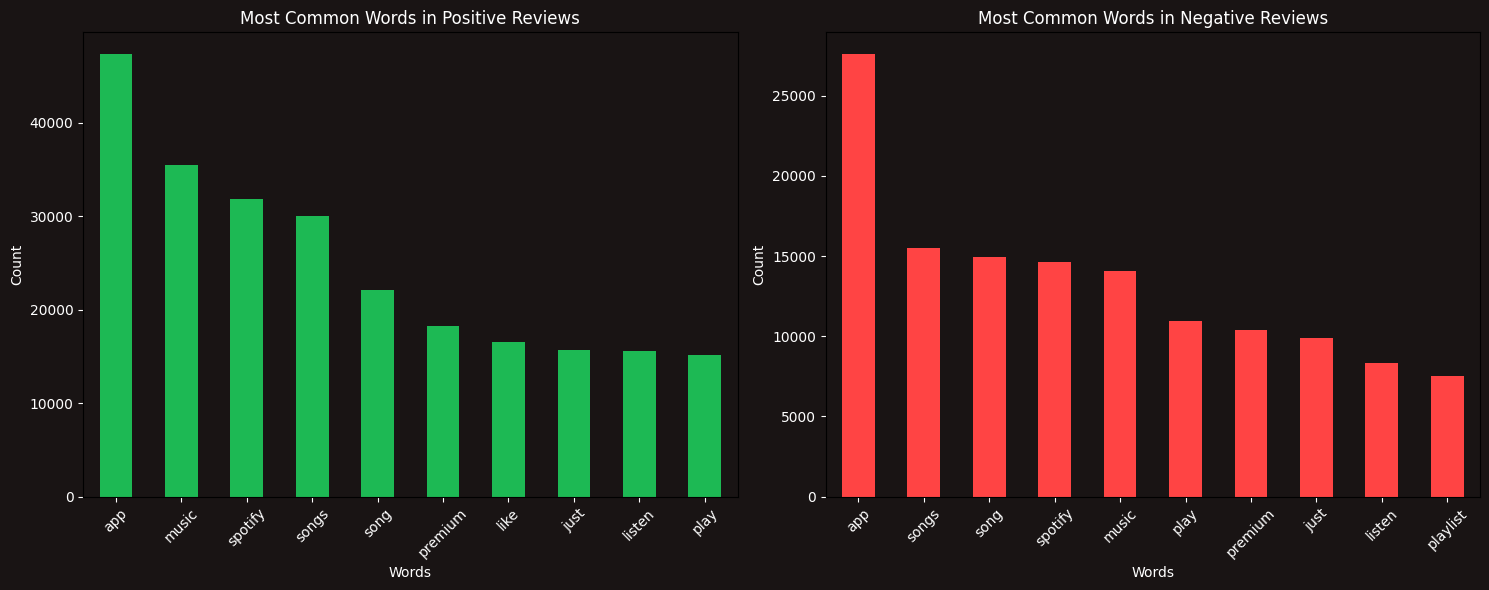

In [23]:
# Visualize common words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor(SPOTIFY_BLACK)

# Positive words plot
positive_words['count'].plot(kind='bar', ax=ax1, color=SPOTIFY_GREEN)
ax1.set_title('Most Common Words in Positive Reviews', color=SPOTIFY_WHITE)
ax1.set_xlabel('Words', color=SPOTIFY_WHITE)
ax1.set_ylabel('Count', color=SPOTIFY_WHITE)
ax1.tick_params(axis='x', rotation=45)

# Negative words plot
negative_words['count'].plot(kind='bar', ax=ax2, color='#ff4444')
ax2.set_title('Most Common Words in Negative Reviews', color=SPOTIFY_WHITE)
ax2.set_xlabel('Words', color=SPOTIFY_WHITE)
ax2.set_ylabel('Count', color=SPOTIFY_WHITE)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/common_words.png', facecolor=SPOTIFY_BLACK, bbox_inches='tight')
plt.show()



In [39]:
print("\nSummary Statistics:")
print(f"Total number of reviews: {len(data)}")
print(f"Average sentiment score: {data['sentiment_score'].mean():.3f} out of 1.")
print("\nMost common words in positive reviews:")
print(positive_words.head())
print("\nMost common words in negative reviews:")
print(negative_words.head())


Summary Statistics:
Total number of reviews: 84165
Average sentiment score: 0.086 out of 1.

Most common words in positive reviews:
         count
app      47305
music    35464
spotify  31877
songs    30002
song     22073

Most common words in negative reviews:
         count
app      27579
songs    15495
song     14958
spotify  14615
music    14075
